Rows: 6185, Tickers: 5


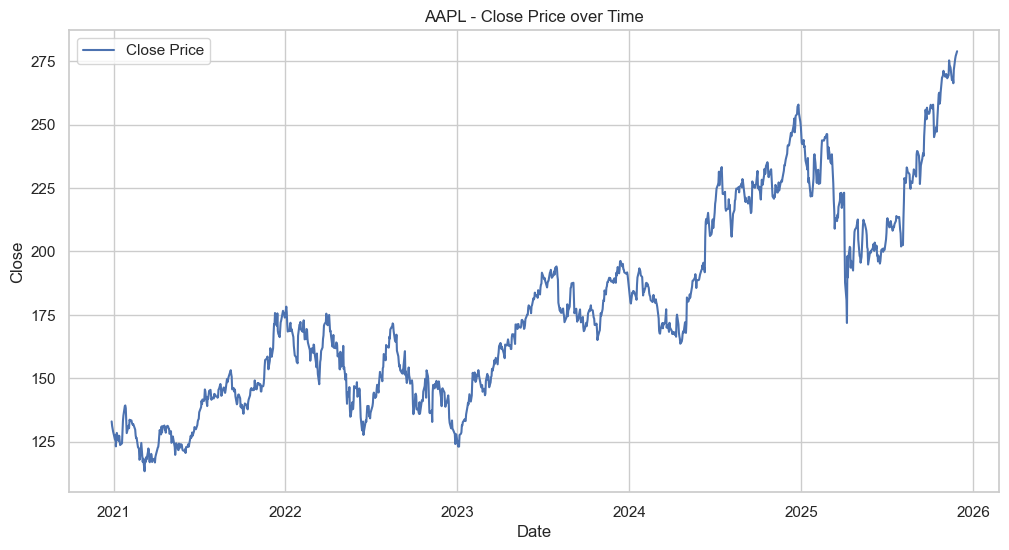

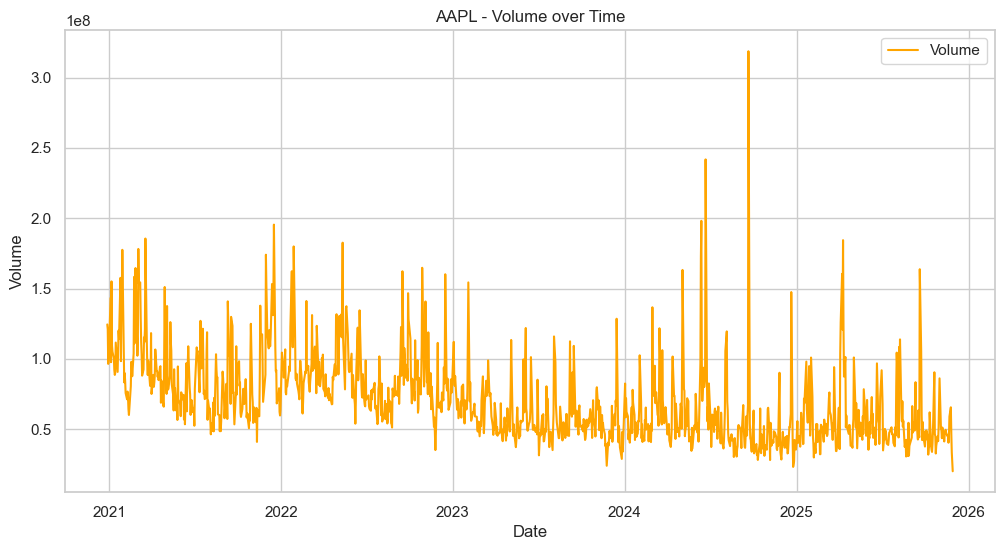

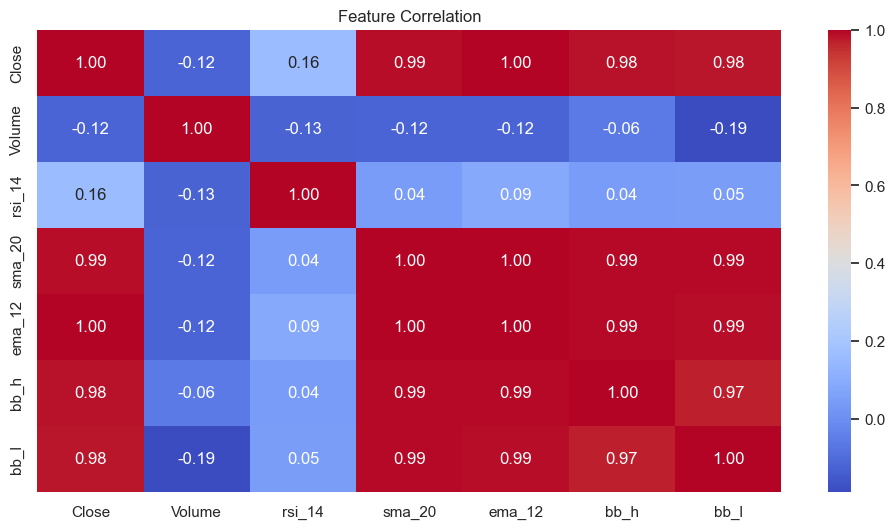

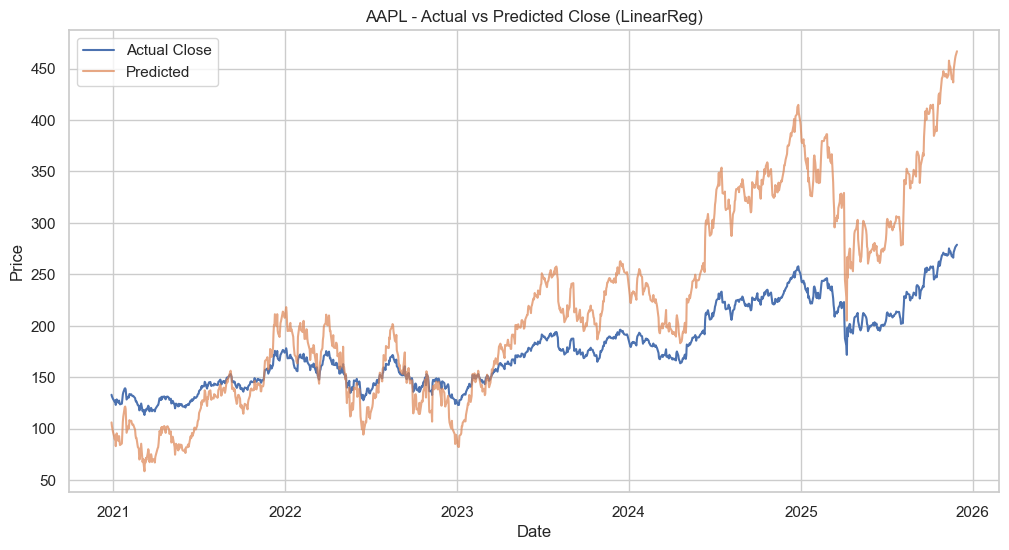

Predicted next day price for AAPL: 466.82


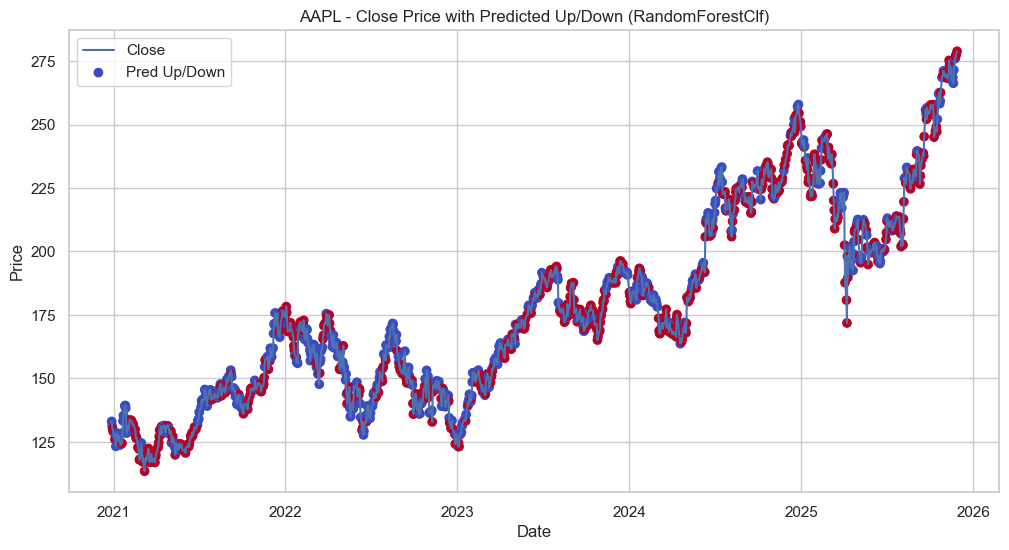

In [4]:
# notebooks/Stock_AI_Prediction_Final.ipynb

# %% [markdown]
# # Phân tích dữ liệu cổ phiếu & Dự đoán giá bằng AI
# 
# Notebook này trực quan hóa dữ liệu, dự đoán giá với model đã train sẵn.
# Dùng model có sẵn: Linear Regression cho regression, RandomForestClf cho classification.

# %%
# 1. IMPORTS
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Thêm src vào sys.path để import module ml
sys.path.append(os.path.abspath("../src"))

from ml.load_all_features import load_all_feature_files
from ml.predict import predict_next_day
from ml.prepare import FEATURES

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,6)

# %%
# 2. LOAD DATA
FEATURE_DIR = os.path.abspath(os.path.join("..", "data", "processed", "features"))

def load_features_from_dir(feature_dir):
    dfs = []
    for file in os.listdir(feature_dir):
        if file.endswith("_features.csv"):
            path = os.path.join(feature_dir, file)
            df = pd.read_csv(path)
            if "Ticker" not in df.columns:
                df["Ticker"] = os.path.basename(file).split("_")[0]
            dfs.append(df)
    if not dfs:
        raise ValueError("No feature files found in " + feature_dir)
    df_all = pd.concat(dfs, ignore_index=True)
    if "Date" in df_all.columns:
        df_all["Date"] = pd.to_datetime(df_all["Date"], errors="coerce")
        df_all = df_all.sort_values(["Ticker", "Date"]).reset_index(drop=True)
    return df_all

df = load_features_from_dir(FEATURE_DIR)
print(f"Rows: {len(df)}, Tickers: {df['Ticker'].nunique()}")
df.head()

# %%
# 3. EDA - giá và volume ticker mẫu
tickers = df['Ticker'].unique()
sample_ticker = tickers[0]
df_sample = df[df['Ticker'] == sample_ticker]

plt.figure()
plt.plot(df_sample['Date'], df_sample['Close'], label='Close Price')
plt.title(f"{sample_ticker} - Close Price over Time")
plt.xlabel("Date")
plt.ylabel("Close")
plt.legend()
plt.show()

plt.figure()
plt.plot(df_sample['Date'], df_sample['Volume'], color='orange', label='Volume')
plt.title(f"{sample_ticker} - Volume over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.show()

# %%
# 4. Feature correlation
plt.figure()
sns.heatmap(df[FEATURES].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()

# %%
# 5. LOAD MODEL HIỆN CÓ
best_reg_model_path = os.path.abspath(os.path.join("..", "models", "LinearReg.pkl"))
reg_model = joblib.load(best_reg_model_path)

best_clf_model_path = os.path.abspath(os.path.join("..", "models", "RandomForestClf.pkl"))
clf_model = joblib.load(best_clf_model_path)

# %%
# 6. VISUALIZE REGRESSION PREDICTIONS
from sklearn.preprocessing import StandardScaler

df_sample_clean = df_sample.dropna()
X_sample = df_sample_clean[FEATURES].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sample)

y_pred = reg_model.predict(X_scaled)

plt.figure()
plt.plot(df_sample_clean['Date'], df_sample_clean['Close'], label='Actual Close')
plt.plot(df_sample_clean['Date'], y_pred, label='Predicted', alpha=0.7)
plt.title(f"{sample_ticker} - Actual vs Predicted Close (LinearReg)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# %%
# 7. PREDICT NEXT-DAY PRICE
next_day_price = predict_next_day(df_sample_clean, best_reg_model_path)
print(f"Predicted next day price for {sample_ticker}: {next_day_price:.2f}")

# %%
# 8. OPTIONAL: PREDICT CLASSIFICATION (giá tăng/giảm)
y_pred_clf = clf_model.predict(X_scaled)
df_sample_clean['Pred_Up'] = y_pred_clf

plt.figure()
plt.plot(df_sample_clean['Date'], df_sample_clean['Close'], label='Close')
plt.scatter(df_sample_clean['Date'], df_sample_clean['Close'], 
            c=df_sample_clean['Pred_Up'], cmap='coolwarm', label='Pred Up/Down')
plt.title(f"{sample_ticker} - Close Price with Predicted Up/Down (RandomForestClf)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()
